In [294]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import pandas as pd
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from Project.utils.storage import youtube_db as db

importlib.reload(db)

<module 'Project.utils.storage.youtube_db' from 'C:\\Users\\Filippo Corti\\Documents\\GitHub\\SocialMediaMining\\Project\\utils\\storage\\youtube_db.py'>

In [3]:
"""
THE YOUTUBE MACHINE LEARNING PIPELINE:

1. Build a DataFrame with [content, podcast_guest, bias, leaning, is_political, sentiment, emotion, llm_label].

2. Extract a sub-DataFrame with only rows that have llm_label.

3. Define Snorkel Labeling Functions

4. Run Snorkel on sub-DataFrame to create 50k labeled instances. We can check which labels were more important.

5. Manually label 150 instances in the entire DataFrame.

6. Create a DataFrame having [content, podcast_guest, bias, leaning, sentiment, emotion, SNORKEL_LABEL].

7. Build a Model using sklearn (Cross Validation and other stuff), training it on the DataFrame on point 6. Check Performance

8. Run the Model on the entire Dataset. Check Performance based on my 150 instances.

At the end, every comment has a label produced by my Classification Model

"""


'\nTHE YOUTUBE MACHINE LEARNING PIPELINE:\n\n1. Build a DataFrame with [content, podcast_guest, bias, leaning, is_political, sentiment, emotion, llm_label].\n\n2. Extract a sub-DataFrame with only rows that have llm_label.\n\n3. Define Snorkel Labeling Functions\n\n4. Run Snorkel on sub-DataFrame to create 50k labeled instances. We can check which labels were more important.\n\n5. Manually label 150 instances in the entire DataFrame.\n\n6. Create a DataFrame having [content, podcast_guest, bias, leaning, sentiment, emotion, SNORKEL_LABEL].\n\n7. Build a Model using sklearn (Cross Validation and other stuff), training it on the DataFrame on point 6. Check Performance\n\n8. Run the Model on the entire Dataset. Check Performance based on my 150 instances.\n\nAt the end, every comment has a label produced by my Classification Model\n\n'

In [4]:
trump_podcasts = [
    "xrFdHO7FH8w",
    "blqIZGXWUpU",
    "s11uIW7wi-E",
    "vC5cHjcgt5g",
    "G80iLTctFuY",
    "qCbfTN-caFI",
    "Ry1IjOft95c",
    "S7BTdUaNQM8",
    "1SsmPh8gCxU",
    "-dmwG54QsKc",
    "nwQil7tcImI",
    "G9lXnwuZ2qs",
    "hBMoPUAeLnY"
]

harris_podcasts = [
    "_KCRsjPCiCI",
    "bzThwqnQJDY",
    "7L4sts7I3xI",
    "pNbwMrBMGgE",
    "Vu5yD3fu6A8",
]

youtube_db = db.SQLiteYoutubeSaver(db_name='../db/youtube.db')

In [311]:
youtube_db.cursor.execute(f"""
SELECT Comments.id, in_reply_to_id, content, video_id, bias, leaning, is_political, sentiment, emotion, llm_label
FROM CommentAnalysis JOIN Comments on Comments.id = CommentAnalysis.id
""")

data = youtube_db.cursor.fetchall()


df = pd.DataFrame(data)
df.columns = ['id', 'in_reply_to_id', 'content', 'video_id', 'bias', 'leaning', 'is_political', 'sentiment', 'emotion', 'llm_label']
df['podcast_guest'] = ['Trump' if video_id in trump_podcasts else 'Harris' for video_id in df['video_id']]
df.drop('video_id', axis=1, inplace=True)



In [312]:
comments_map = {
    x[1]["id"]: x[1]
    for x in df.iterrows()
}

In [313]:
df

,id,in_reply_to_id,content,bias,leaning,is_political,sentiment,emotion,llm_label,podcast_guest
0,UgyfluKW3Ug3sy7JipJ4AaABAg,None,Best Podcast of All-time? 🤔🔥,RIGHT,RIGHT,0,Positive,joy,Republican,Trump
1,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWgAZknY6,UgyfluKW3Ug3sy7JipJ4AaABAg,Definitely my favorite!,RIGHT,LEFT,0,Positive,joy,Republican,Trump
2,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpEh0att,UgyfluKW3Ug3sy7JipJ4AaABAg,"No, best guest",RIGHT,RIGHT,0,Positive,joy,Republican,Trump
3,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpMKmUEI,UgyfluKW3Ug3sy7JipJ4AaABAg,Probably,RIGHT,LEFT,0,Neutral,anticipation,Republican,Trump
4,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWt4CmVAq,UgyfluKW3Ug3sy7JipJ4AaABAg,Under 30 seconds,RIGHT,RIGHT,0,Neutral,anticipation,Neutral,Trump
...,...,...,...,...,...,...,...,...,...,...
114695,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AA9xuMlvsYZ,UgyHorsmGTU9LHUXCBJ4AaABAg,How do you check the numbers from your phone ...,RIGHT,RIGHT,0,Negative,disgust,None,Harris
114696,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AA9yMqEcrPM,UgyHorsmGTU9LHUXCBJ4AaABAg,@@BruceDragon-sf1tr just google it fam. I prom...,LEFT,RIGHT,0,Neutral,optimism,None,Harris
114697,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AAA-zsorgCI,UgyHorsmGTU9LHUXCBJ4AaABAg,its now 34k to 88k now lolol,LEFT,LEFT,0,Positive,joy,None,Harris
114698,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AAA04ke2mdj,UgyHorsmGTU9LHUXCBJ4AaABAg,@@BruceDragon-sf1trjust add it to your browser...,LEFT,RIGHT,0,Neutral,anger,None,Harris


In [346]:
df_with_llm_labels = df[df["llm_label"].notna()].copy()

In [347]:
df_with_llm_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52451 entries, 0 to 93638
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              52451 non-null  object
 1   in_reply_to_id  49587 non-null  object
 2   content         52451 non-null  object
 3   bias            52451 non-null  object
 4   leaning         52451 non-null  object
 5   is_political    52451 non-null  int64 
 6   sentiment       52451 non-null  object
 7   emotion         52451 non-null  object
 8   llm_label       52451 non-null  object
 9   podcast_guest   52451 non-null  object
dtypes: int64(1), object(9)
memory usage: 4.4+ MB


In [348]:
df_with_llm_labels

,id,in_reply_to_id,content,bias,leaning,is_political,sentiment,emotion,llm_label,podcast_guest
0,UgyfluKW3Ug3sy7JipJ4AaABAg,None,Best Podcast of All-time? 🤔🔥,RIGHT,RIGHT,0,Positive,joy,Republican,Trump
1,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWgAZknY6,UgyfluKW3Ug3sy7JipJ4AaABAg,Definitely my favorite!,RIGHT,LEFT,0,Positive,joy,Republican,Trump
2,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpEh0att,UgyfluKW3Ug3sy7JipJ4AaABAg,"No, best guest",RIGHT,RIGHT,0,Positive,joy,Republican,Trump
3,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpMKmUEI,UgyfluKW3Ug3sy7JipJ4AaABAg,Probably,RIGHT,LEFT,0,Neutral,anticipation,Republican,Trump
4,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWt4CmVAq,UgyfluKW3Ug3sy7JipJ4AaABAg,Under 30 seconds,RIGHT,RIGHT,0,Neutral,anticipation,Neutral,Trump
...,...,...,...,...,...,...,...,...,...,...
93634,UgwtZ5FZ8C7dTnDZAKV4AaABAg,None,Curious why she didn’t get called out for not ...,LEFT,RIGHT,1,Negative,anger,Democratic,Harris
93635,Ugzq-N-U0VpXLVuamXN4AaABAg,None,"She already thinks she has won. ""When I was Vi...",RIGHT,RIGHT,1,Negative,anticipation,Republican,Harris
93636,Ugzq-N-U0VpXLVuamXN4AaABAg.A9eP05BLNGaA9eWjEMHm_h,Ugzq-N-U0VpXLVuamXN4AaABAg,Technically she can be the president if she us...,RIGHT,RIGHT,1,Neutral,anticipation,Republican,Harris
93637,Ugzq-N-U0VpXLVuamXN4AaABAg.A9eP05BLNGaA9eex9dkNBB,Ugzq-N-U0VpXLVuamXN4AaABAg,That's what people need to realize. If she was...,LEFT,RIGHT,1,Negative,anger,Democratic,Harris


In [349]:
# Label Space
REPUBLICAN = 0
DEMOCRATIC = 1
NEUTRAL = 2
ABSTAIN = -1

In [350]:
@labeling_function()
def lf_llm(x):
    match x.llm_label:
        case "Republican":
            return REPUBLICAN
        case "Democratic":
            return DEMOCRATIC
        case "Neutral":
            return NEUTRAL
        case _:
            return ABSTAIN


@labeling_function()
def lf_bias(x):
    if not x.is_political: return NEUTRAL
    match x.bias:
        case "LEFT":
            return DEMOCRATIC
        case "RIGHT":
            return REPUBLICAN
    return ABSTAIN


@labeling_function()
def lf_leaning(x):
    if not x.is_political: return NEUTRAL
    match x.leaning:
        case "RIGHT":
            return REPUBLICAN
        case "LEFT":
            return DEMOCRATIC
    return ABSTAIN

@labeling_function()
def lf_bias_leaning(x):
    if not x.is_political: return NEUTRAL
    match (x.bias, x.leaning):
        case ("LEFT", "LEFT"): return DEMOCRATIC
        case ("RIGHT", "RIGHT"): return REPUBLICAN
    return ABSTAIN

@labeling_function()
def lf_llm_leaning(x):
    match (x.llm_label, x.leaning):
        case ("Democratic", "LEFT"): return DEMOCRATIC
        case ("Republican", "RIGHT"): return REPUBLICAN
    return ABSTAIN

@labeling_function()
def lf_not_political(x):
    return NEUTRAL if x.is_political == 0 else ABSTAIN

@labeling_function()
def lf_negative_sentiment(x):
    match x.sentiment:
        case "Negative":
            return DEMOCRATIC if x.podcast_guest == "Trump" else REPUBLICAN
        case "Positive":
            return REPUBLICAN if x.podcast_guest == "Trump" else DEMOCRATIC
    return ABSTAIN


@labeling_function()
def lf_emotion(x):
    match x.emotion:
        case "joy" | "surprise":
            return REPUBLICAN if x.podcast_guest == "Trump" else DEMOCRATIC
        case "anger" | "disgust":
            return DEMOCRATIC if x.podcast_guest == "Trump" else REPUBLICAN
    return ABSTAIN


@labeling_function()
def lf_bias_sentiment(x):
    match (x.bias, x.sentiment):
        case ("RIGHT", "Positive"): return REPUBLICAN
        case ("LEFT", "Positive"): return DEMOCRATIC
        case ("RIGHT", "Negative"): return DEMOCRATIC
        case ("LEFT", "Negative"): return REPUBLICAN
    return ABSTAIN

@labeling_function()
def lf_content(x):
    content = x.content.casefold()
    if "magat" in content: return DEMOCRATIC
    if "maga" in content: return REPUBLICAN
    if "censor" in content: return REPUBLICAN
    if "harris 202" in content: return DEMOCRATIC # For Harris 2024 and 2025
    if "trump 202" in content: return REPUBLICAN # For Trump 2024 and 2025
    if "kamala" in content and "great" in content:  return DEMOCRATIC
    if "trump" in content and "save" in content: return REPUBLICAN
    if "current administration" in content: return REPUBLICAN
    return ABSTAIN

@labeling_function()
def lf_guest(x):
    if x.podcast_guest == "Trump": return REPUBLICAN
    if x.podcast_guest == "Harris": return DEMOCRATIC
    return ABSTAIN


In [369]:
lfs = [
    #lf_llm,
    #lf_bias,
    #lf_leaning,
    lf_bias_leaning,
    lf_llm_leaning,
    lf_not_political,
    #lf_negative_sentiment,
    lf_emotion,
    lf_bias_sentiment,
    lf_content,
    lf_guest
]

applier = PandasLFApplier(lfs)
L = applier.apply(df_with_llm_labels)

100%|██████████| 52451/52451 [00:05<00:00, 9497.68it/s] 


In [370]:
LFAnalysis(L, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_bias,0,"[0, 1, 2]",0.945454,0.945454,0.900364
lf_bias_leaning,1,"[0, 1, 2]",0.722999,0.722999,0.691388
lf_llm_leaning,2,"[0, 1]",0.427885,0.427885,0.398543
lf_not_political,3,[2],0.440220,0.440220,0.440220
lf_emotion,4,"[0, 1]",0.730815,0.730815,0.699224
lf_bias_sentiment,5,"[0, 1]",0.815027,0.815027,0.779432
lf_content,6,"[0, 1]",0.020095,0.020095,0.017540
lf_guest,7,"[0, 1]",1.000000,0.994547,0.938152


In [371]:
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train=L, n_epochs=500, log_freq=100)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 886.96epoch/s]
INFO:root:Finished Training


In [372]:
snorkel_labels = label_model.predict(L)

In [373]:
df_with_llm_labels["snorkel_labels"] = snorkel_labels
print(f"Republican: {len([l for l in snorkel_labels if l == 0])}")
print(f"Democratic: {len([l for l in snorkel_labels if l == 1])}")
print(f"Neutral: {len([l for l in snorkel_labels if l == 2])}")

Republican: 14990
Democratic: 14276
Neutral: 23185


In [374]:
confidence_levels = np.max(label_model.predict_proba(L), axis=1)
df_with_llm_labels["confidence"] = confidence_levels
print(np.count_nonzero(confidence_levels))
print(np.count_nonzero(confidence_levels >= 0.9))

52451
37843


In [375]:
df_with_llm_labels

,id,in_reply_to_id,content,bias,leaning,is_political,sentiment,emotion,llm_label,podcast_guest,snorkel_labels,confidence
0,UgyfluKW3Ug3sy7JipJ4AaABAg,None,Best Podcast of All-time? 🤔🔥,RIGHT,RIGHT,0,Positive,joy,Republican,Trump,2,0.997015
1,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWgAZknY6,UgyfluKW3Ug3sy7JipJ4AaABAg,Definitely my favorite!,RIGHT,LEFT,0,Positive,joy,Republican,Trump,2,0.998858
2,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpEh0att,UgyfluKW3Ug3sy7JipJ4AaABAg,"No, best guest",RIGHT,RIGHT,0,Positive,joy,Republican,Trump,2,0.997015
3,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpMKmUEI,UgyfluKW3Ug3sy7JipJ4AaABAg,Probably,RIGHT,LEFT,0,Neutral,anticipation,Republican,Trump,2,0.997355
4,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWt4CmVAq,UgyfluKW3Ug3sy7JipJ4AaABAg,Under 30 seconds,RIGHT,RIGHT,0,Neutral,anticipation,Neutral,Trump,2,0.997355
...,...,...,...,...,...,...,...,...,...,...,...,...
93634,UgwtZ5FZ8C7dTnDZAKV4AaABAg,None,Curious why she didn’t get called out for not ...,LEFT,RIGHT,1,Negative,anger,Democratic,Harris,0,0.924992
93635,Ugzq-N-U0VpXLVuamXN4AaABAg,None,"She already thinks she has won. ""When I was Vi...",RIGHT,RIGHT,1,Negative,anticipation,Republican,Harris,0,0.957556
93636,Ugzq-N-U0VpXLVuamXN4AaABAg.A9eP05BLNGaA9eWjEMHm_h,Ugzq-N-U0VpXLVuamXN4AaABAg,Technically she can be the president if she us...,RIGHT,RIGHT,1,Neutral,anticipation,Republican,Harris,0,0.957429
93637,Ugzq-N-U0VpXLVuamXN4AaABAg.A9eP05BLNGaA9eex9dkNBB,Ugzq-N-U0VpXLVuamXN4AaABAg,That's what people need to realize. If she was...,LEFT,RIGHT,1,Negative,anger,Democratic,Harris,0,0.924992


In [376]:
labelled_data = pd.read_csv("../data/manual_label_sample.csv", sep=";")
ids = [x for x in labelled_data["id"] if x in df_with_llm_labels["id"]]

labelled_data["id"] = labelled_data["id"].astype(str)
df_filtered = df_with_llm_labels[df_with_llm_labels["confidence"] >= 0]
df_with_llm_labels["id"] = df_filtered["id"].astype(str)

common_ids = labelled_data["id"][labelled_data["id"].isin(df_with_llm_labels["id"])]

print(len(common_ids))

manual_labels = labelled_data.set_index("id").loc[common_ids, "label"].tolist()
snorkel_labels = df_with_llm_labels.set_index("id").loc[common_ids, "snorkel_labels"].tolist()
llm_labels = df_with_llm_labels.set_index("id").loc[common_ids, "llm_label"].tolist()
leaning_labels = df_with_llm_labels.set_index("id").loc[common_ids, "leaning"].tolist()

llm_labels = [{"Republican": 0, "Democratic": 1, "Neutral": 2}.get(l) for l in llm_labels]
leaning_labels = [{"RIGHT": 0, "LEFT": 1, "CENTER": 2}.get(l) for l in leaning_labels]


210


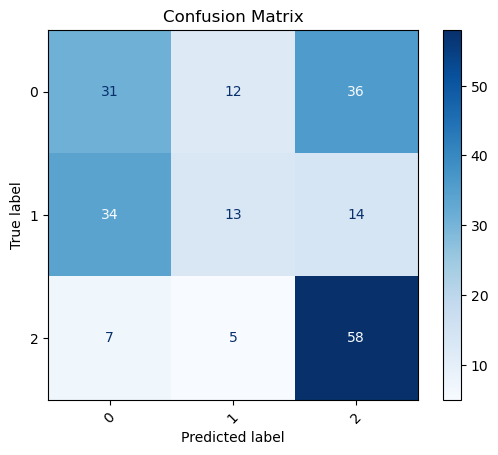

              precision    recall  f1-score   support

  Republican       0.43      0.39      0.41        79
  Democratic       0.43      0.21      0.29        61
     Neutral       0.54      0.83      0.65        70

    accuracy                           0.49       210
   macro avg       0.47      0.48      0.45       210
weighted avg       0.47      0.49      0.45       210



In [377]:
# Generate the confusion matrix
cm = confusion_matrix(manual_labels, snorkel_labels, labels=sorted(set(manual_labels + snorkel_labels)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(manual_labels + snorkel_labels)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(manual_labels, snorkel_labels, target_names=["Republican", "Democratic", "Neutral"]))

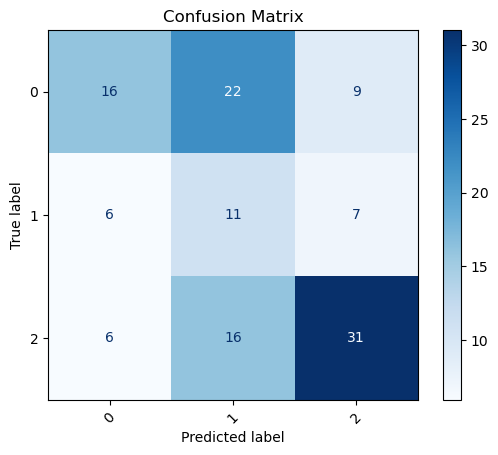

              precision    recall  f1-score   support

  Republican       0.57      0.34      0.43        47
  Democratic       0.22      0.46      0.30        24
     Neutral       0.66      0.58      0.62        53

    accuracy                           0.47       124
   macro avg       0.49      0.46      0.45       124
weighted avg       0.54      0.47      0.49       124



In [328]:
# Generate the confusion matrix
cm = confusion_matrix(manual_labels, llm_labels, labels=sorted(set(manual_labels + llm_labels)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(manual_labels + llm_labels)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(manual_labels, llm_labels, target_names=["Republican", "Democratic", "Neutral"]))

In [269]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Step 1: Load your labeled dataset
# Assume you already have a DataFrame with 'content' and 'label' columns
# Labels should be 0 (REP), 1 (DEM), 2 (NEUTRAL)
df2 = pd.read_csv("../data/manual_label_sample.csv", sep=";")

df2["content"] = [comments_map[id][2] for id in df2["id"]]

# Step 3: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    df2["content"], df2["label"], test_size=0.2, stratify=df2["label"], random_state=42
)

# Step 4: Build classifier pipeline
clf = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
)

# Step 5: Train and evaluate
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Republican", "Democratic", "Neutral"]))

              precision    recall  f1-score   support

  Republican       0.47      0.50      0.48        16
  Democratic       0.42      0.67      0.52        12
     Neutral       0.50      0.21      0.30        14

    accuracy                           0.45        42
   macro avg       0.46      0.46      0.43        42
weighted avg       0.47      0.45      0.43        42



C:\Users\Filippo Corti\AppData\Local\Temp\ipykernel_7332\2517101434.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df2["content"] = [comments_map[id][2] for id in df2["id"]]
